In [1]:
import pandas as pd
import numpy as np
import os, re, datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
from typing import Callable

import torch
import torch.nn as nn

In [2]:
dfs = []
csv_files_with_category = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_with_category_[0-9]*_of_[0-9]*\.csv', f)]
for g in csv_files_with_category:
    dfs.append(pd.read_csv(os.path.join("transformed_data", g)))
df = pd.concat(dfs)

In [3]:
df

,object_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_917,feature_918,feature_919,category,category_0,category_1,category_2,category_3,category_4,category_5
0,015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd...,0,0,1,76,1,0,35,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
1,b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe...,0,0,1,82,1,0,57,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
2,7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec...,0,0,1,85,1,0,64,1,0,...,0.0,0.0,0.0,c,0,0,0,1,0,0
3,a19cac5720bd4f47228521419907354dd0e5420ae01a00...,0,0,1,83,1,0,59,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
4,34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588b...,0,0,1,83,1,0,44,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9755,0e9d7fda34bb2d659f1c60f1f59055432f6d9ed6de8fbc...,1,0,0,87,1,0,0,1,0,...,0.0,0.0,0.0,c,0,0,0,1,0,0
9756,7525d02dc9b3d280b8d7bdca5c4a3f7b44210bb2ede810...,0,0,1,83,1,0,65,1,0,...,0.0,0.0,0.0,c,0,0,0,1,0,0
9757,0dde61beb042c90fcd519489765535c5eb3d8cb7e47724...,0,0,1,85,1,0,68,1,0,...,0.0,0.0,0.0,c,0,0,0,1,0,0
9758,2efd800466427791edc26b562f07b22e4bdc5ec0ffea30...,0,0,1,82,1,0,79,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1


In [4]:
model_input = df.iloc[:, 1:921].values.astype(np.float32)
model_output = df.iloc[:, 922:].values.astype(np.float32)

In [5]:
model_input

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [6]:
model_output

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [7]:
tensor_input = torch.tensor(model_input, dtype=torch.float32)
tensor_output = torch.tensor(model_output, dtype=torch.float32)

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [9]:
input_train, input_test, output_train, output_test = train_test_split(tensor_input, tensor_output, test_size=0.3, random_state=666)

train_dataset = TensorDataset(input_train, output_train)
test_dataset = TensorDataset(input_test, output_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [10]:
@dataclass
class NNLayerConfig:
    in_size: int
    out_size: int
    activation: Callable

@dataclass
class NNCOnfig:
    dropout_rate: float | None
    with_batch_norm: bool
    with_residual: bool
    layers: list[NNLayerConfig]

def Swish():
    '''
    x * 1 / ( 1 + exp(-x) )
    '''
    return lambda x: x * torch.sigmoid(x)    


class ConfigurableBlock(nn.Module):
    def __init__(self, in_size: int, out_size: int, activation: Callable, with_batch_norm: bool = False, with_residual: bool = False):
        super(ConfigurableBlock, self).__init__()
        self.layer = nn.Linear(in_size, out_size)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(out_size)
        self.with_batch_norm = with_batch_norm
        self.with_residual = with_residual
        
        if with_residual and in_size != out_size:
            self.projection = nn.Linear(in_size, out_size)
        else:
            self.projection = None
    
    def forward(self, x):
        if self.with_residual:
            residual = x
            if self.projection:
                residual = self.projection(residual)
        out = self.layer(x)
        if self.with_batch_norm:
            out_norm = self.batch_norm(out)
        out_act = self.activation(out) if not self.with_batch_norm else self.activation(out_norm)
        if self.with_residual:
            out_residual = out_act + residual
        return out_act if not self.with_residual else out_residual

class ConfigurableNN(nn.Module):
    def __init__(self, config: NNCOnfig):
        super(ConfigurableNN, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer in enumerate(config.layers):
            self.layers.append(ConfigurableBlock(layer.in_size, layer.out_size, layer.activation, config.with_batch_norm, config.with_residual))
            if i < len(config.layers) - 1 and config.dropout_rate is not None:
                self.layers.append(nn.Dropout(config.dropout_rate))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

config = NNCOnfig(
    dropout_rate=None,
    with_batch_norm=True,
    with_residual=True,
    layers=[
        NNLayerConfig(920, 1840, nn.LeakyReLU),
        NNLayerConfig(1840, 920, nn.Tanh),
        NNLayerConfig(920, 460, nn.Tanh),
        NNLayerConfig(460, 230, nn.LeakyReLU),
        NNLayerConfig(230, 6, nn.ReLU),
    ]
)

model = ConfigurableNN(config)

In [26]:
loss_fn = nn.MSELoss()
LEARNING_RATE = 0.01
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
import pprint
from contextlib import contextmanager

@contextmanager
def plot_context():
    fig = plt.figure()
    try:
        yield fig
    finally:
        plt.close(fig)

class SummaryWriter:

    def __init__(self, num_epoch: int, learning_rate: float, model_config) -> None:
        self.current_time = datetime.datetime.now()
        self.current_time_for_name = self.current_time.strftime("%Y-%m-%d_%H-%M-%S")
        self.model_export_path = "models"
        self.training_instance_export_path = os.path.join(self.model_export_path, self.current_time_for_name)
        self.num_epoch = num_epoch
        self.learning_rate = learning_rate
        self.model_config = model_config
        self.summary_md_lines = []
        self.epoch_steps_lines = []
        self.best_epoch = None
        self.best_epoch_validation_loss = None
        self.epoch_validation_losses = []
        self._create_dirs()


    def add_epoch_summary(self, epoch: int, validation_loss: float, test_loader) -> None:
        validation_loss_reduced = validation_loss/len(test_loader)
        if self.best_epoch_validation_loss is None:
            self.best_epoch_validation_loss = validation_loss_reduced
            self.best_epoch = epoch
        if self.best_epoch_validation_loss > validation_loss_reduced:
            self.best_epoch_validation_loss = validation_loss_reduced
            self.best_epoch = epoch
        self.epoch_steps_lines.append(f'Epoch {epoch}/{self.num_epoch}, Validation Loss: {validation_loss_reduced}')
        self.epoch_validation_losses.append(validation_loss_reduced)
    
    def print_content_to_files(self):
        self._generate_summary_content()
        with open(os.path.join(self.training_instance_export_path, "summary.md"), "w") as f:
            f.write("\n".join(self.summary_md_lines))
        self._save_plot()
        self._save_plot_log()

    def _save_plot(self):
        with plot_context():
            plt.plot(self.epoch_validation_losses)
            plt.xlabel("Epoch")
            plt.ylabel("Validation Loss")
            plt.title("Validation Loss over Epochs")
            plt.savefig(os.path.join(self.training_instance_export_path, "validation_loss.png"))

    def _save_plot_log(self):
        with plot_context():
            plt.plot(np.log(self.epoch_validation_losses))
            plt.xlabel("Epoch")
            plt.ylabel("Validation Loss")
            plt.title("Validation Loss over Epochs on a log scale")
            plt.savefig(os.path.join(self.training_instance_export_path, "validation_loss_log.png"))

    def _generate_summary_content(self):
        summary_section_title = self.current_time.strftime("%d/%m/%Y - %H:%M'%S''")
        self.summary_md_lines.append(f"PoE model training of {summary_section_title}")
        self.summary_md_lines.append("========================")
        self.summary_md_lines.append("")
        self.summary_md_lines.append("training set description")
        self.summary_md_lines.append("------------------------")
        self.summary_md_lines.append(f"learning rate: {self.learning_rate}")
        self.summary_md_lines.append(f"number of epochs: {self.num_epoch}")
        self.summary_md_lines.append("model configuration: ")
        pretty_config = pprint.pformat(self.model_config, indent=2)
        for line in pretty_config.split("\n"):
            self.summary_md_lines.append(f"  {line}")
        self.summary_md_lines.append("")
        self.summary_md_lines.append("training results")
        self.summary_md_lines.append("----------------")
        self.summary_md_lines.append(f"best epoch: {self.best_epoch}")
        self.summary_md_lines.append(f"best epoch validation loss: {self.best_epoch_validation_loss}")
        self.summary_md_lines.append("")
        self.summary_md_lines.append("### ecpoh resutls")
        for line in self.epoch_steps_lines:
            self.summary_md_lines.append(line)

    def _create_dirs(self):
        os.makedirs(self.model_export_path, exist_ok=True)
        os.makedirs(self.training_instance_export_path, exist_ok=False)


In [31]:
num_epochs = 20
overall_loss_for_epoch = None
best_epoch = None

summary_writer = SummaryWriter(num_epochs, LEARNING_RATE, config)
    

torch.autograd.set_detect_anomaly(True)

loss_progression = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs.float())

        loss = loss_fn(outputs, labels.float())
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            val_loss += loss_fn(outputs, labels.float()).item()
    if overall_loss_for_epoch is None or val_loss/len(test_loader) < overall_loss_for_epoch:
        overall_loss_for_epoch = val_loss/len(test_loader)
        best_epoch = epoch+1
        torch.save(model.state_dict(), os.path.join(summary_writer.training_instance_export_path, f'model.pth'))
    
    loss_progression.append(val_loss/len(test_loader))
    summary_writer.add_epoch_summary(epoch+1, val_loss, test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(test_loader)}')

print(f'Best epoch: {best_epoch}, Loss: {overall_loss_for_epoch}')

Epoch 1/20, Validation Loss: 1337094685172.821
Epoch 2/20, Validation Loss: 7837397783.475983
Epoch 3/20, Validation Loss: 8501092272.069869
Epoch 4/20, Validation Loss: 5405228104.663755
Epoch 5/20, Validation Loss: 7448076150345.781
Epoch 6/20, Validation Loss: 4606034389.51965
Epoch 7/20, Validation Loss: 1190613487.930131
Epoch 8/20, Validation Loss: 771304618.0611354
Epoch 9/20, Validation Loss: 625611091.5633187
Epoch 10/20, Validation Loss: 811859135.441048
Epoch 11/20, Validation Loss: 4981632197.310043
Epoch 12/20, Validation Loss: 1711695418.9694324
Epoch 13/20, Validation Loss: 1047393424.4890829
Epoch 14/20, Validation Loss: 4801965908.401747
Epoch 15/20, Validation Loss: 868235651.7030568
Epoch 16/20, Validation Loss: 99815476.90829694
Epoch 17/20, Validation Loss: 9182653824.558952
Epoch 18/20, Validation Loss: 200385110.7423581
Epoch 19/20, Validation Loss: 235034452.8558952
Epoch 20/20, Validation Loss: 1918146581.6593885
Best epoch: 16, Loss: 99815476.90829694


In [32]:
summary_writer.print_content_to_files()

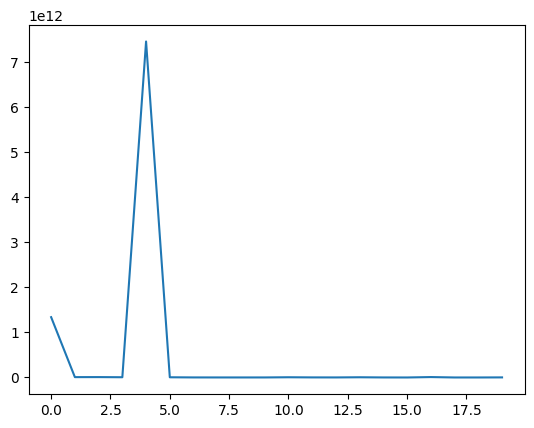

In [33]:
plt.plot(loss_progression)

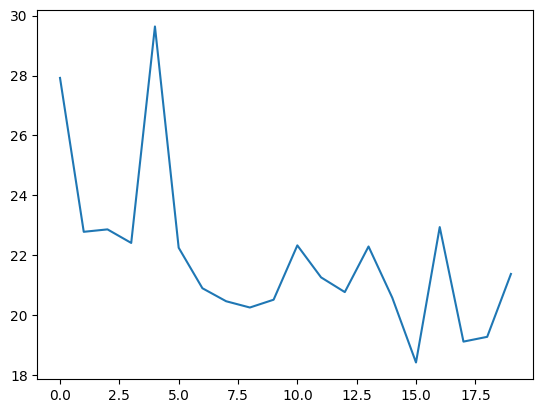

In [34]:
# this is a plot of the loss progression transformed in a logaritmic scale to illustrate the actual progression
plt.plot(np.log(loss_progression))